#### Simple Market Direction Classier demo

#### Imports

In [1]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import torch
import sys
import warnings

sys.path.insert(1, './modules')

import modules.configs as cfg
import modules.logistic_regression_classifier as lrc
import modules.performance_report as pr   
import modules.plot_results as pltr 
import modules.dnn_classifier as dnnc   
import modules.dnn_data_loader as ddl 
import modules.feature_engineering as fe                   

warnings.filterwarnings("ignore")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\ADE\miniconda3\envs\ai-thursdays-env\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\ADE\miniconda3\envs\ai-thursdays-env\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\ADE\miniconda3\envs\ai-thursdays-env\Lib\site-packages\ipykernel\kernelapp.py", line 758, in start
    self

Device: cpu


#### Get the S & P data

In [2]:
def get_sp_data(
    file_path: str = cfg.S_P_DATA_PATH,
    symbol: str = "MSFT",
    sma_short_window: int = cfg.SMA_SHORT_WINDOW,
    sma_long_window: int = cfg.SMA_LONG_WINDOW,
    n_lags: int = 5
    ) -> pd.DataFrame:
    """
    Load S & P data from a CSV file.
    :param file_path: Path to the CSV file.
    :param symbol: Stock symbol to filter the data.
    :return: DataFrame containing the S & P data.
    """
    # data_df = pd.read_csv(file_path, parse_dates=['Date'], index_col=['Date'])
    data_df = pd.read_csv(file_path, index_col=False)
    data_df = data_df[data_df['Symbol'] == symbol]
    data_df = data_df.sort_values(by='Date').reset_index(drop=True)
    data_df.index = data_df['Date']
    #data_df.set_index('Date', inplace=True)
    # msft_data_df = data_df[['Date', 'Close', 'Volume']]
    msft_data_df = data_df[['Close', 'High','Low', 'Open', 'Volume']]
    msft_data_df.rename(
        columns={
            'Close': 'price',
            'High': 'high',
            'Low': 'low',
            'Open': 'open', 
            'Volume': 'volume'},
        inplace=True
    )
    msft_data_df['return'] = np.log(msft_data_df['price'] / msft_data_df['price'].shift(1))

    # Calculate SMAs
    msft_data_df['sma_short_window'] = msft_data_df['price'].rolling(window=sma_short_window).mean()
    msft_data_df['sma_long_window'] = msft_data_df['price'].rolling(window=sma_long_window).mean()

    # Create lag features for closing price (e.g., previous 1, 2, and 3 days)
    # for lag in range(1, n_lags):
    #     msft_data_df[f'close_lag_{lag}'] = msft_data_df['return'].shift(lag)    

    # Drop rows with NaN values resulting from rolling and shifting calculations
    msft_data_df.dropna(inplace=True)

    # Create the target variable (1 for up, 0 for down)
    # We use the stock's direction from the next day's close price
    # msft_data_df['direction'] = (msft_data_df['price'].shift(-1) > msft_data_df['price']).astype(int) 
    msft_data_df['direction'] = np.where(msft_data_df['sma_short_window'] > msft_data_df['sma_long_window'], 1.0, 0.0) 

    # Additional feature engineering can be done here
    msft_data_df['momentum_30'] = fe.compute_momenturm_indicator(msft_data_df['price'], n=30)
    msft_data_df['momentum_100'] = fe.compute_momenturm_indicator(msft_data_df['price'], n=100)
    msft_data_df['stochastic_200'] = fe.compute_stochastic_oscilator(
        msft_data_df['price'], 
        msft_data_df['high'], 
        msft_data_df['low'], 
        n=200,
        id=1)
    msft_data_df['stochastic_30'] = fe.compute_stochastic_oscilator(
        msft_data_df['price'], 
        msft_data_df['high'], 
        msft_data_df['low'], 
        n=30,
        id=1)
    msft_data_df['rsi_100'] = fe.compute_rsi(msft_data_df['price'], period=100)
    msft_data_df['rsi_30'] = fe.compute_rsi(msft_data_df['price'], period=30)
    msft_data_df['rsi_200'] = fe.compute_rsi(msft_data_df['price'], period=200)
    

    # Drop columns
    drop_columns = ['sma_short_window', 'sma_long_window']     
    msft_data_df.drop(columns=drop_columns, inplace=True)

    # Drop the last row, as it has no next day direction
    msft_data_df.dropna(inplace=True)

    return msft_data_df


def create_features_and_target(
    data_df: pd.DataFrame,

    ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create features and target arrays from the DataFrame.
    :param data_df: DataFrame containing the S & P data.    
    :return: Tuple of features array and target array.
    """
        
    X = data_df.drop(columns=['direction', 'return', 'volume', 'open'])
    y = data_df['direction']    
    return X, y

def partition_data(
    X: pd.DataFrame,
    y: pd.DataFrame,
    test_size: float = cfg.TEST_SIZE,
    val_size: float = cfg.VAL_SIZE,
    random_state: int = cfg.RANDOM_SEED
    ) -> tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    """
    Partition the data into training, validation, and test sets.
    :param X: Features array.
    :param y: Target array.
    :param test_size: Fraction of data to be used as test set.
    :param val_size: Fraction of remaining data to be used as validation set.
    :param random_state: Random seed for reproducibility.
    :return: Tuple of training, validation, and test sets for features and target.
    """
    X.sort_index(inplace=True)
    y.index = X.index
        
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    
    X_train_val.sort_index(inplace=True)
    X_test.sort_index(inplace=True)
    y_train_val.index = X_train_val.index
    y_test.index = X_test.index


    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, 
        y_train_val, 
        test_size=val_relative_size,
        random_state=random_state, 
        shuffle=False
    )

    X_train.sort_index(inplace=True)
    X_val.sort_index(inplace=True)
    y_train.index = X_train.index
    y_val.index = X_val.index   
    
    # X_test_index = pd.to_datetime(X_test.index).date
    X_test_index = X_test.index
        
    return X_train, X_val, X_test, y_train, y_val, y_test, X_test_index


sp_data = get_sp_data()
print(sp_data.head())
print(sp_data.info())
X,y = create_features_and_target(sp_data)
print(f"X data shape: {X.shape}")
print(f"y data shape: {y.shape}")
X_train, X_val, X_test, y_train, y_val, y_test, X_test_index = partition_data(X, y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}") 
print(f"X_test_index shape: {X_test_index.shape}")   




            price   high        low       open      volume    return  \
Date                                                                   
2010-12-30  27.85  28.00  27.780001  27.920000  20786100.0 -0.004300   
2010-12-31  27.91  27.92  27.629999  27.799999  24752000.0  0.002152   
2011-01-03  27.98  28.18  27.920000  28.049999  53443800.0  0.002505   
2011-01-04  28.09  28.17  27.850000  27.940001  54405600.0  0.003924   
2011-01-05  28.00  28.01  27.770000  27.900000  58998700.0 -0.003209   

            direction  momentum_30  momentum_100  stochastic_200  \
Date                                                               
2010-12-30        1.0     2.040001      2.240000       58.449225   
2010-12-31        1.0     2.340000      2.840000       58.027816   
2011-01-03        1.0     2.139999      3.119999       58.069958   
2011-01-04        1.0     2.400000      3.600000       59.081335   
2011-01-05        1.0     2.270000      3.600000       59.460602   

            stocha

#### Analyse the correction of the features with the Target (direction)

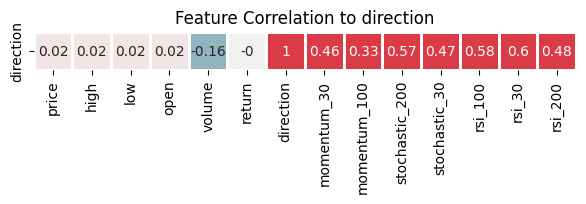

In [3]:
pltr.create_correlation_matrix(sp_data,'direction',figsize=(7,0.5))

#### Run training and prediction of market direction using Logistic Regression classifier 

##### Normalize the data

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)  # IMPORTANT: fit only on training data

X_train_scale = scaler.transform(X_train)
X_val_scale = scaler.transform(X_val)
X_test_scale = scaler.transform(X_test)

##### Run Logistic regression classifier

--------------------------------------------------
Logistic Regression Classifier Accuracy: 81.25%
Logistic Regression Classifier AUC: 74.79%
--------------------------------------------------



--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.58      0.66       165
         1.0       0.83      0.92      0.87       363

    accuracy                           0.81       528
   macro avg       0.80      0.75      0.76       528
weighted avg       0.81      0.81      0.80       528

--------------------------------------------------



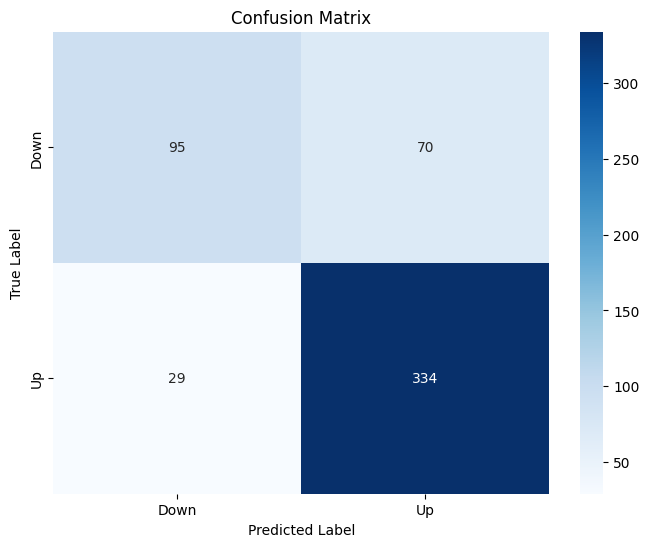

In [5]:
log_reg_classifier = lrc.LogisticRegressionClassifier()
log_reg_classifier.train(X_train, y_train)  
y_pred_lr = log_reg_classifier.predict(X_test)
accuracy = log_reg_classifier.evaluate(X_test, y_test)
auc = pr.calculate_auc(y_test, y_pred_lr)  
print(cfg.LINE_DIVIDER)
print(f"Logistic Regression Classifier Accuracy: {accuracy * 100:.2f}%")
print(f"Logistic Regression Classifier AUC: {auc * 100:.2f}%")
print(cfg.LINE_DIVIDER)
print("\n\n")
report = pr.generate_performance_report(y_test, y_pred_lr)
print(report)
pltr.plot_confusion_matrix(y_test, y_pred_lr, class_names=['Down', 'Up'])


##### Analysis of the logistic regression classifier results

##### Performance of the logistic regression classifier

In [14]:
lr_strategy_report_df = pr.generate_trading_strategy_performance_report(
    sp_data_df=sp_data,
    X_test_index=X_test_index,
    y_test=y_test,
    y_pred=y_pred_lr
    )
lr_strategy_report_df.head(5)

,predict_price_direction,actual_price_direction,return,strategy_return,actual_return,strategy_return_cum,actual_return_cum
Date,,,,,,,
2022-11-15,-1,-1,0.001737,-0.001737,-0.001737,0.998264,0.998264
2022-11-16,-1,-1,-0.000992,0.000992,0.000992,0.999255,0.999255
2022-11-17,-1,-1,-0.000207,0.000207,0.000207,0.999462,0.999462
2022-11-18,1,-1,-0.001905,-0.001905,0.001905,0.997560,1.001368
2022-11-21,1,-1,0.003435,0.003435,-0.003435,1.000992,0.997934


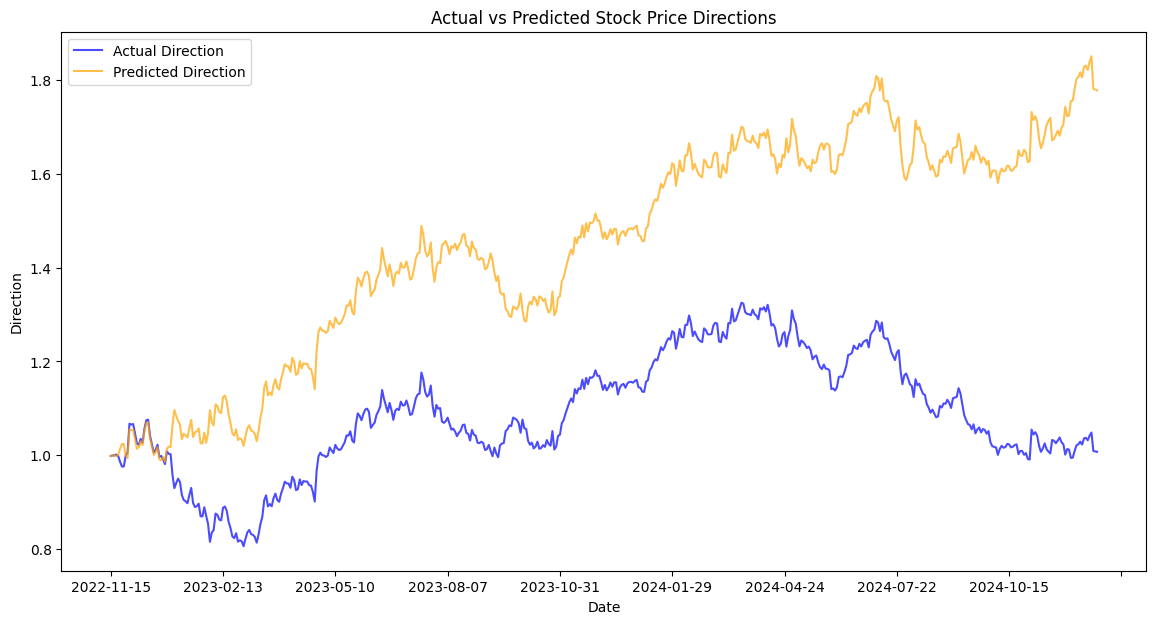

In [ ]:
pltr.plot_strategy_actual_vs_predicted(
    actual=lr_strategy_report_df.actual_return_cum,
    predicted=lr_strategy_report_df.strategy_return_cum,
    dates=lr_strategy_report_df.index
)

#### Using DNN Classifer to predict the market direction

In [8]:
dnn_predictor = dnnc.DNNMarketDirectionPredictor(input_size=X_train_scale.shape[1])
train_loader, val_loader, test_loader = ddl.create_dataloader(
    X_train_scale, 
    y_train.values, 
    X_val_scale, 
    y_val.values, 
    X_test_scale, 
    y_test.values)
  


In [9]:
dnn_predictor.train(train_loader, val_loader)
y_test, y_prob, y_pred_dnn = dnn_predictor.predict(test_loader)




Epoch 01 | train_loss=0.5418 | val_auc=0.8659 | val_acc=0.8052
Epoch 02 | train_loss=0.3718 | val_auc=0.8807 | val_acc=0.8213
Epoch 03 | train_loss=0.3509 | val_auc=0.8878 | val_acc=0.8068
Epoch 04 | train_loss=0.3474 | val_auc=0.8949 | val_acc=0.7907
Epoch 05 | train_loss=0.3439 | val_auc=0.8993 | val_acc=0.8035
Epoch 06 | train_loss=0.3236 | val_auc=0.9030 | val_acc=0.8068
Epoch 07 | train_loss=0.3184 | val_auc=0.9055 | val_acc=0.8052
Epoch 08 | train_loss=0.3149 | val_auc=0.9076 | val_acc=0.7939
Epoch 09 | train_loss=0.3061 | val_auc=0.9081 | val_acc=0.8100
Epoch 10 | train_loss=0.3068 | val_auc=0.9076 | val_acc=0.8180
Epoch 11 | train_loss=0.3007 | val_auc=0.9067 | val_acc=0.8132
Epoch 12 | train_loss=0.2918 | val_auc=0.9069 | val_acc=0.8116
Epoch 13 | train_loss=0.2996 | val_auc=0.9072 | val_acc=0.8132
Epoch 14 | train_loss=0.2934 | val_auc=0.9068 | val_acc=0.8148
Early stopping after epoch 14. Best epoch was 9 with val_auc 0.9081
Training finished in 3.2s. Best epoch: 9, Best val

##### Report DNN classifier performance 

--------------------------------------------------
Logistic Regression Classifier Accuracy: 81.25%
Logistic Regression Classifier AUC: 82.31%
--------------------------------------------------



--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75       165
         1.0       0.91      0.84      0.87       363

    accuracy                           0.83       528
   macro avg       0.80      0.82      0.81       528
weighted avg       0.84      0.83      0.83       528

--------------------------------------------------



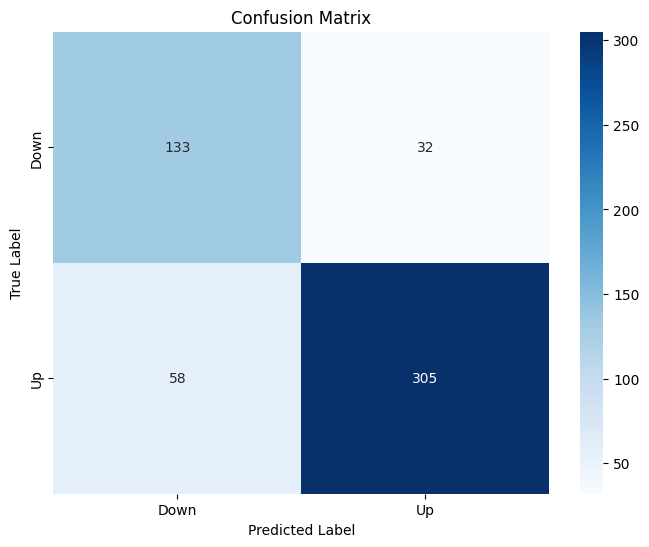

In [10]:
auc = pr.calculate_auc(y_test, y_pred_dnn)  
print(cfg.LINE_DIVIDER)
print(f"Logistic Regression Classifier Accuracy: {accuracy * 100:.2f}%")
print(f"Logistic Regression Classifier AUC: {auc * 100:.2f}%")
print(cfg.LINE_DIVIDER)
print("\n\n")
report = pr.generate_performance_report(y_test, y_pred_dnn)
print(report)
pltr.plot_confusion_matrix(y_test, y_pred_dnn, class_names=['Down', 'Up'])

#### Report the trading strategy performance

In [11]:
dnn_strategy_report_df = pr.generate_trading_strategy_performance_report(
    sp_data_df=sp_data,
    X_test_index=X_test_index,
    y_test=y_test,
    y_pred=y_pred_dnn
    )
dnn_strategy_report_df.head(5)

,predict_price_direction,actual_price_direction,return,strategy_return,actual_return,strategy_return_cum,actual_return_cum
Date,,,,,,,
2022-11-15,-1,-1,0.001737,-0.001737,-0.001737,0.998264,0.998264
2022-11-16,-1,-1,-0.000992,0.000992,0.000992,0.999255,0.999255
2022-11-17,-1,-1,-0.000207,0.000207,0.000207,0.999462,0.999462
2022-11-18,-1,-1,-0.001905,0.001905,0.001905,1.001368,1.001368
2022-11-21,1,-1,0.003435,0.003435,-0.003435,1.004814,0.997934


#### Plot the DNN classifier strategy performance

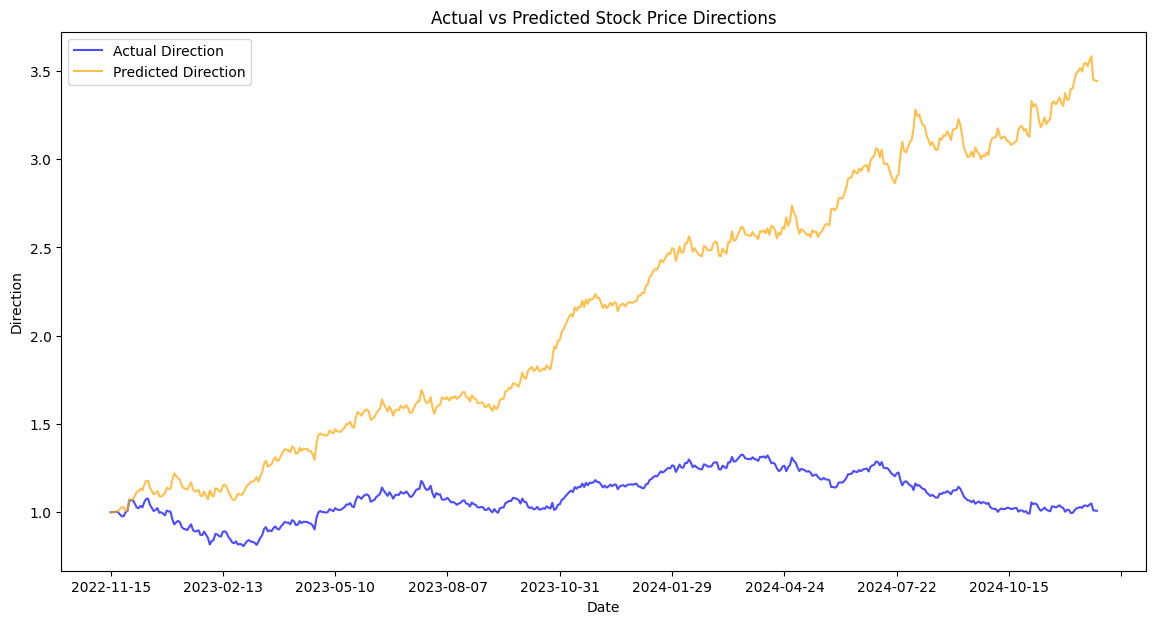

In [12]:
pltr.plot_strategy_actual_vs_predicted(
    actual=dnn_strategy_report_df.actual_return_cum,
    predicted=dnn_strategy_report_df.strategy_return_cum,
    dates=dnn_strategy_report_df.index
)

In [22]:
all_data = pd.read_csv(cfg.S_P_DATA_PATH, index_col=False)
filter_1 = all_data['Symbol'] == 'MSFT'
filter_2 = all_data['Symbol'] == 'AMZN'
filter_3 = all_data['Symbol'] == 'GOOGL'
filter_4 = all_data['Symbol'] == 'NVDA'
filter_5 = all_data['Symbol'] == 'AAPL'
subset_data_df = all_data[(filter_1 | filter_2 | filter_3 | filter_4 | filter_5 )]
subset_data_df.to_csv('./data/subset_sp_data.csv', index=False)